In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import scipy 
import anndata
import scvi.dataset as scvd
import sys
from sklearn.utils import shuffle
import iqplot

data_path = "." 

/home/joeyta/anaconda3/lib/python3.8/site-packages/pytorch_lightning/metrics/__init__.py:43: LightningDeprecationWarning: `pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
  rank_zero_deprecation(
/home/joeyta/anaconda3/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


In [ ]:
import requests
import os

#La Manno et al. 2020, Developing Mouse Brain data
from tqdm import tnrange, tqdm_notebook
def download_file(doi,ext):
	url = 'https://api.datacite.org/dois/'+doi+'/media'
	r = requests.get(url).json()
	netcdf_url = r['data'][0]['attributes']['url']
	r = requests.get(netcdf_url,stream=True)
	#Set file name
	fname = doi.split('/')[-1]+ext
	#Download file with progress bar
	if r.status_code == 403:
		print("File Unavailable")
	if 'content-length' not in r.headers:
		print("Did not get file")
	else:
		with open(fname, 'wb') as f:
			total_length = int(r.headers.get('content-length'))
			pbar = tnrange(int(total_length/1024), unit="B")
			for chunk in r.iter_content(chunk_size=1024):
				if chunk:
					pbar.update()
					f.write(chunk)
		return fname

In [2]:
import bokeh.plotting
bokeh.io.output_notebook()

Loading BokehJS ...

In [20]:
os.system("mkdir data")
os.chdir("data")


In [ ]:
os.system("wget --quiet https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/ypx3sw2f7c-3.zip")
os.system("unzip ypx3sw2f7c")
os.system("unzip *")

In [ ]:
#smartseq.csv (count matrix)
download_file('10.22002/D1.2075','.gz')
os.system("gunzip *.gz")

In [ ]:
os.system("mv D1.2075 smartseq.csv")

In [3]:
smartseq = pd.read_csv((data_path + "/smartseq.csv")) #FIGURE OUT WHERE THIS CAME FROM

In [4]:
smartseq = smartseq.transpose()[1:]

In [5]:
SM_metadata = pd.read_csv(data_path + "/SMART-seq_VMH_metadata.csv")

In [6]:
SM_metadata = SM_metadata.dropna()

In [7]:
SM_metadata["sample_name"].values

array(['SM-GE4R2_S062_E1-50', 'SM-GE4SI_S356_E1-50',
       'SM-GE4SI_S172_E1-50', ..., 'SM-D9D7G_S25_E1-50',
       'SM-D9D7M_S89_E1-50', 'SM-D9E6R_S81_E1-50'], dtype=object)

In [8]:
smartseq = smartseq.loc[SM_metadata["sample_name"].values]

In [9]:
# read in SMARTseq data
SM_adata = anndata.AnnData(smartseq)

/home/joeyta/anaconda3/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [10]:
# Add relevant metadata to anndata object
SM_adata.obs["sample_name"] = SM_metadata["sample_name"].values
SM_adata.obs["cca_cluster_id"] = SM_metadata["cca_cluster_id"].values
SM_adata.obs["cca_cluster"] = SM_metadata["cca_cluster_label"].values
SM_adata.obs["sex_label"] = SM_metadata["sex_label"].values
SM_adata.obs["cca_cluster_color"] = SM_metadata["cca_cluster_color"].values

In [11]:
# seed for reproducability
np.random.seed(seed = 15)

In [12]:
metadata = pd.read_csv(data_path +'/10x_metadata_VMH_neuron.csv')

In [13]:
cells_metadata = pd.read_csv(data_path +'/10x_metadata_cell.csv')
cells_metadata.dropna(inplace = True)

In [101]:
def create_dataset(folder):
    """This function takes in a folder that is the name of the 10X data sample and performs the entire process for creating and formatting 
    the anndata object, and then returns an AnnDataset"""
    path = data_path + "/10x_VMH_" + folder + "/"
    matrix = anndata.read_mtx(path + 'matrix.mtx')
    origin = '10x_VMH_' + folder
    batch = cells_metadata.loc[cells_metadata['orig.ident'] == origin , ['sample_name']].values[0][0].split('_')[0]
    print(batch)
    t2g = pd.read_csv(path + 'genes.tsv', header = None, names = ['gene_id', 'gene_name'], sep = '\t')
    barcodes = pd.read_csv(path + 'barcodes.tsv', header = None, names = ['barcode'])
    print(len(barcodes))
    barcodes['barcode'] = barcodes['barcode'].str.strip('-1')
    barcodes['barcode'] = str(batch) + '_' + barcodes['barcode']
    barcodes['cluster_id'] = np.empty(len(barcodes.barcode)).fill(0)
    barcodes['cluster_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['cca_id'] = np.empty(len(barcodes.barcode)).fill(0)
    barcodes['cca_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['cca_color'] = ['not_listed'] * len(barcodes.barcode)
    barcodes['sex_label'] = ['not_listed'] * len(barcodes.barcode)
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['sex_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['sex_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cluster_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['neuron_cluster_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_id']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_id']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_label']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_label']].values
    barcodes.loc[barcodes.barcode.isin(cells_metadata['sample_name']), ['cca_color']] = cells_metadata.loc[cells_metadata.sample_name.isin(barcodes['barcode']), ['VMH_neuron_cca_cluster_color']].values
    barcodes.loc[barcodes["cca_label"] == "Esr1_2", "cca_label"] = "Esr1_2|3"
    barcodes.loc[barcodes["cca_label"] == "Esr1_3", "cca_label"] = "Esr1_2|3"
    genes = t2g.gene_name.values
    matrix = matrix.T
    matrix.var["gene_name"] = genes
    matrix.var.index = matrix.var["gene_name"]
    matrix.obs["cell_barcode"] = barcodes.barcode.values
    matrix.obs["sex_label"] = barcodes.sex_label.values
    matrix.obs["cca_cluster"] = barcodes.cca_label.values
    matrix.obs['cca_cluster_id'] = barcodes.cca_id.values
    matrix.obs['cca_cluster_color'] = barcodes.cca_color.values
    matrix.obs['sample_name'] = [folder] * len(barcodes.barcode)
    values = np.nan_to_num((matrix.obs.cca_cluster_id).astype(np.float))
    labeled_cells = np.where(values != 0)[0]
    print(len(labeled_cells))
    val = matrix.n_obs - 1 
    #random_cells = np.random.randint(low = 0, high = val, size = 1500)
    matrix = matrix[labeled_cells, :]
    if (len(labeled_cells) == 1):
        return 
    return scvd.AnnDatasetFromAnnData(matrix)
#     return matrix
    #return labeled_cells

In [102]:
folders = ["Female_Control_1", "Female_Mating_not_receptive_1", "Female_Mating_not_receptive_2", 
           "Female_Mating_not_receptive_3", "Female_Plain_1", "Male_Aggression_1", "Male_Aggression_2", 
           "Male_Aggression_3", 
           "Male_Control_1", "Male_Control_2", "Male_Control_3", "Male_M-F_CI_dangled_1", "Male_M-M_CI_dangled_2",
           "Male_M-F_CI_pencil_cup_1","Male_M-M_CI_dangled_1", "Male_M-M_CI_pencil_cup_1", "Male_Mating_1",
           "Male_Others_1", "Male_Others_2", "Male_Others_3", "Male_Others_4", "Male_Plain_1", "Male_Plain_2", 
           "Male_Social_Fear_Singly-housed_1", "Male_Social_Fear_Singly-housed_2", "Male_Social_Fear_Group-housed_1"]

In [103]:
print(np.unique(cells_metadata['orig.ident']))

['10x_VMH_Female_Control_1' '10x_VMH_Female_Mating_not_receptive_1'
 '10x_VMH_Female_Mating_not_receptive_2'
 '10x_VMH_Female_Mating_not_receptive_3' '10x_VMH_Female_Plain_1'
 '10x_VMH_Male_Aggression_1' '10x_VMH_Male_Aggression_2'
 '10x_VMH_Male_Aggression_3' '10x_VMH_Male_Control_1'
 '10x_VMH_Male_Control_2' '10x_VMH_Male_Control_3'
 '10x_VMH_Male_M-F_CI_dangled_1' '10x_VMH_Male_M-F_CI_pencil_cup_1'
 '10x_VMH_Male_M-M_CI_dangled_1' '10x_VMH_Male_M-M_CI_dangled_2'
 '10x_VMH_Male_M-M_CI_pencil_cup_1' '10x_VMH_Male_Mating_1'
 '10x_VMH_Male_Others_1' '10x_VMH_Male_Others_2' '10x_VMH_Male_Others_3'
 '10x_VMH_Male_Others_4' '10x_VMH_Male_Plain_1' '10x_VMH_Male_Plain_2'
 '10x_VMH_Male_Social_Fear_Group-housed_1'
 '10x_VMH_Male_Social_Fear_Singly-housed_1'
 '10x_VMH_Male_Social_Fear_Singly-housed_2']


In [104]:
l = []

In [105]:
len(folders)

26

In [106]:
# create dataset for each separate sample and concatenates them
for f in folders:
    print(f)
    l.append(create_dataset(f))

Female_Control_1
4
10030
3194
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downsampled from 3194 to 3194 cells                                                 
Female_Mating_not_receptive_1
15
9454
1405
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                        

1855
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downsampled from 1855 to 1855 cells                                                 
Male_M-M_CI_dangled_2
26
4919
1472
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing t

WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downsampled from 1732 to 1732 cells                                                 
Male_Social_Fear_Singly-housed_1
17
8478
1825
INFO     Dense size under 1Gb, casting to dense format (np.ndarray).                         
WARNING  Gene names are not unique.                                                          
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Downs

In [107]:
# removes any datasets that did not have any entries
l = list(filter(None, l))

In [108]:
gene_dataset = scvd.GeneExpressionDataset()

In [109]:
# combine all datasets into 1
gene_dataset.populate_from_datasets(l)

INFO     Merging datasets. Input objects are modified in place.                              
INFO     Gene names and cell measurement names are assumed to have a non-null intersection   
         between datasets.                                                                   
INFO     Keeping 27998 genes                                                                 
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data        

INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data                                         
INFO     Remapping labels to [0,N]                                                           
INFO     Remapping batch_indices to [0,N]                                                    
INFO     Computing the library size for the new data        

In [110]:
adata = gene_dataset.to_anndata()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [111]:
# Parameter settings we use throughout the notebook

num_TSNE = 2
state = 42
metric = "euclidean"
n_neighbors = 30
num_PCA = 40
num_NCA = 10

# Filtering criteria
cell_threshold = 100
gene_threshold = 2

mito_criteria = 5

n_top_genes = 2000

n_bins = 20

flavor="seurat"

In [112]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy import stats

from collections import OrderedDict
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.preprocessing import scale
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from matplotlib import cm
from matplotlib.lines import Line2D

def nd(arr):
    return np.asarray(arr).reshape(-1)
def yex(ax):
    lims = [np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()])]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    return ax

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

import warnings
warnings.filterwarnings('ignore')

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

Pre-processing of data following filtering outlined in Kim et al., 2019

In [113]:
adata.obs["cell_counts"] = adata.X.sum(axis=1)
adata.var["gene_counts"] = nd(adata.X.sum(axis=0))

adata.obs["n_genes"] = nd((adata.X>0).sum(axis=1))
adata.var["n_cells"] = nd((adata.X>0).sum(axis=0))

mito_genes = adata.var_names.str.startswith('mt-')
adata.obs["percent_mito"] = adata[:,mito_genes].X.sum(axis=1)/adata.X.sum(axis=1)*100

In [114]:
SM_adata.obs["cell_counts"] = SM_adata.X.sum(axis=1)
SM_adata.var["gene_counts"] = nd(SM_adata.X.sum(axis=0))

SM_adata.obs["n_genes"] = nd((SM_adata.X>0).sum(axis=1))
SM_adata.var["n_cells"] = nd((SM_adata.X>0).sum(axis=0))

SM_mito_genes = SM_adata.var_names.str.startswith('mt-')
SM_adata.obs["percent_mito"] = SM_adata[:,SM_mito_genes].X.sum(axis=1)/SM_adata.X.sum(axis=1)*100

In [115]:
adata.obs["pass_count_filter"] = adata.obs["cell_counts"] > cell_threshold
adata.obs["pass_mito_filter"] = adata.obs.percent_mito < mito_criteria
adata.var["pass_gene_filter"] = adata.var["n_cells"] > gene_threshold

In [116]:
SM_adata.obs["pass_count_filter"] = SM_adata.obs["cell_counts"] > cell_threshold
SM_adata.obs["pass_mito_filter"] = SM_adata.obs.percent_mito < mito_criteria
SM_adata.var["pass_gene_filter"] = SM_adata.var["n_cells"] > gene_threshold

In [117]:
cell_mask = np.logical_and(adata.obs["pass_count_filter"].values, adata.obs["pass_mito_filter"].values)
gene_mask = adata.var["pass_gene_filter"].values

In [118]:
SM_cell_mask = np.logical_and(SM_adata.obs["pass_count_filter"].values, SM_adata.obs["pass_mito_filter"].values)
SM_gene_mask = SM_adata.var["pass_gene_filter"].values

In [119]:
print("Current Shape: {:,} cells x {:,} genes".format(adata.shape[0], adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(cell_mask.sum(), gene_mask.sum()))

Current Shape: 41,580 cells x 27,998 genes
    New shape: 23,261 cells x 21,375 genes


In [120]:
print("Current Shape: {:,} cells x {:,} genes".format(SM_adata.shape[0], SM_adata.shape[1]))
print("    New shape: {:,} cells x {:,} genes".format(SM_cell_mask.sum(), SM_gene_mask.sum()))

Current Shape: 1,078 cells x 30,862 genes
    New shape: 1,078 cells x 23,568 genes


In [121]:
SM_data = SM_adata[SM_cell_mask, SM_gene_mask]

In [122]:
SM_data.layers["raw"] = SM_data.X
scale_num = 1000000
SM_data.layers["norm"] = normalize(SM_data.X, norm="l1", axis=1)*scale_num
SM_data.layers["log1p"] = np.log1p(SM_data.layers["norm"])
SM_data.uns = OrderedDict([("log1p", {"base":None})])
SM_data.X = SM_data.layers["log1p"]

In [123]:
data = adata[cell_mask, gene_mask]

In [124]:
data.layers["raw"] = data.X

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [125]:
scale_num = 1000000
data.layers["norm"] = normalize(data.X, norm="l1", axis=1)*scale_num

In [126]:
data.layers["log1p"] = np.log1p(data.layers["norm"])
data.uns = OrderedDict([("log1p", {"base":None})])

In [127]:
data.X = data.layers["log1p"]

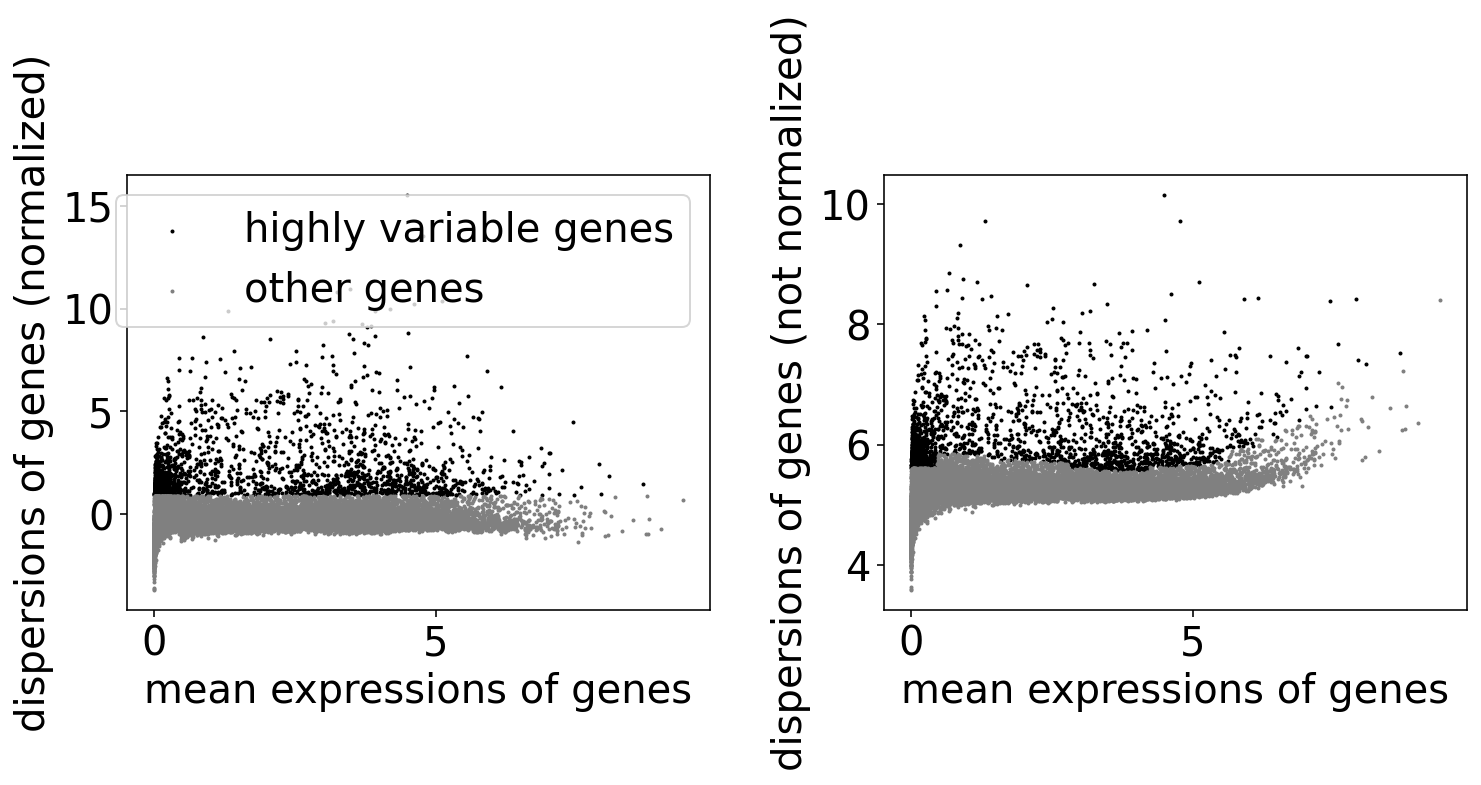

In [128]:
sc.pp.highly_variable_genes(data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
hvg_mask = data.var.highly_variable.values
sc.pl.highly_variable_genes(data)

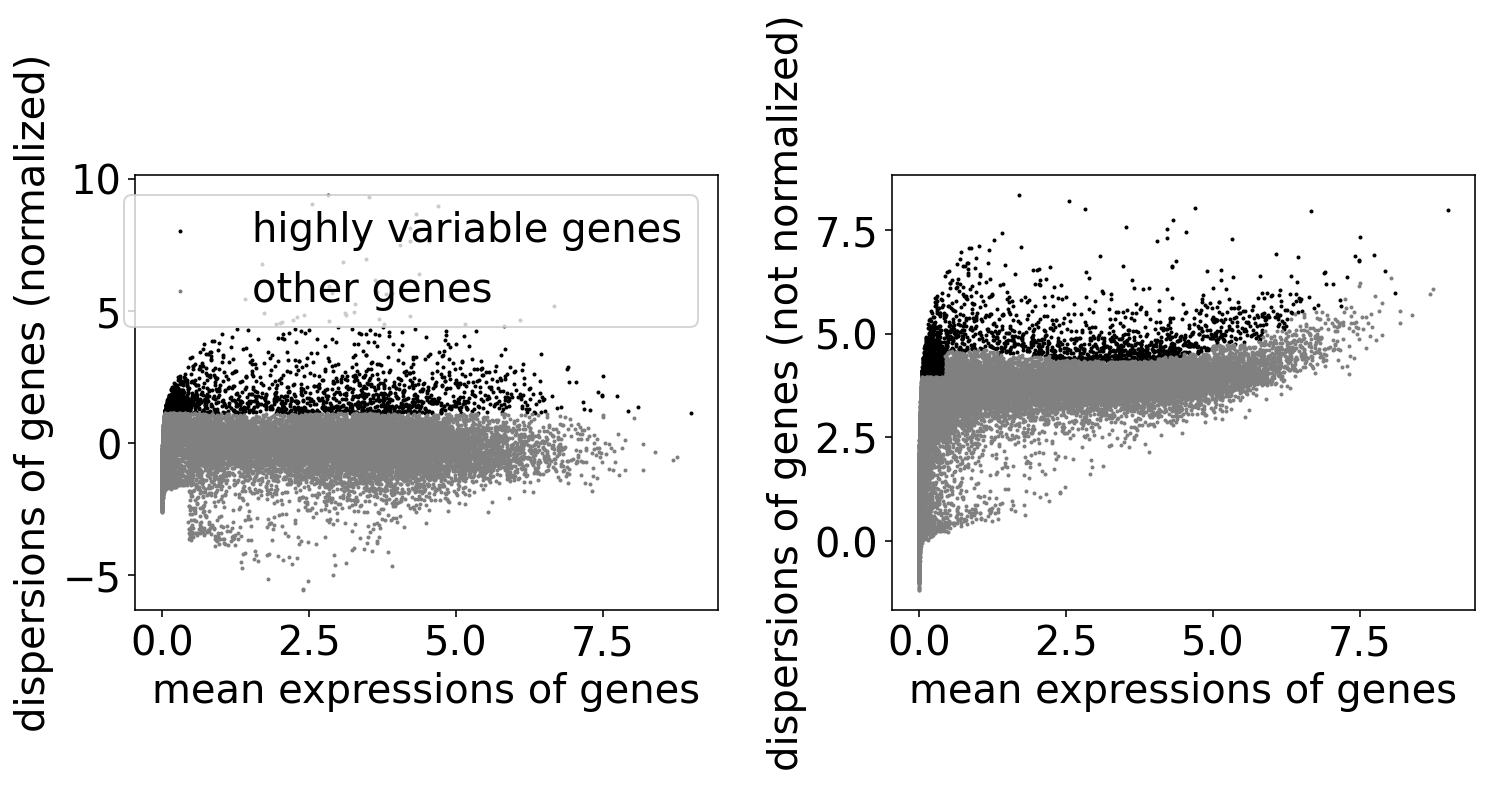

In [129]:
sc.pp.highly_variable_genes(SM_data, n_top_genes=n_top_genes, flavor=flavor, n_bins=n_bins)
SM_hvg_mask = SM_data.var.highly_variable.values
sc.pl.highly_variable_genes(SM_data)

In [130]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = data.layers["log1p"]
data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
data.X = data.layers["scale"]

del mat

CPU times: user 20 s, sys: 7.69 s, total: 27.7 s
Wall time: 27.7 s


In [131]:
%%time
# Scaling operation cannot be performed on the sparse matrix, so we make a dense matrix
mat = SM_data.layers["log1p"]
SM_data.layers["scale"] = scale(mat, axis=0, with_mean=True, with_std=True, copy=True)
SM_data.X = SM_data.layers["scale"]

del mat

CPU times: user 1.01 s, sys: 329 ms, total: 1.34 s
Wall time: 1.33 s


Save matrices and hvg gene lists

In [132]:
hvg_data = data[:, hvg_mask]
SM_hvg_data = SM_data[:, SM_hvg_mask]
combined = hvg_data.concatenate(SM_hvg_data, join = "outer")

In [ ]:
np.save("SM_gene_names.npy", SM_hvg_mask)

In [133]:
scipy.io.mmwrite("tenx_hvg_raw.mtx", hvg_data.layers["raw"])
hvg_data.write_csvs("tenx_hvg")

writing .csv files to tenx_hvg


In [ ]:
allGenes = pd.DataFrame()
allGenes['gene_name'] = list(hvg_data.var_names)
allGenes.to_csv('var.csv')

In [134]:
scipy.io.mmwrite("smartseq_hvg_raw.mtx", SM_hvg_data.layers["raw"])
SM_hvg_data.write_csvs("SM_hvg")

writing .csv files to SM_hvg


In [46]:
combined.X = np.nan_to_num(combined.X)

Save combined anndata objects (count matrices) across conditions

In [47]:
combined.write('comboVMH.h5ad')

... storing 'cca_cluster' as categorical
... storing 'sample_name' as categorical
... storing 'sex_label' as categorical
... storing 'cell_types' as categorical
... storing 'cell_barcode' as categorical
... storing 'cca_cluster_color' as categorical
... storing 'gene_name-0' as categorical
... storing 'pass_gene_filter-0' as categorical
... storing 'highly_variable-0' as categorical
... storing 'pass_gene_filter-1' as categorical
... storing 'highly_variable-1' as categorical
